<a href="https://colab.research.google.com/github/chuang-ma-ku/optimal-classifier/blob/main/LPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cvxpy as cp
import csv
from cvxpy import log_sum_exp, sum, Minimize, Problem
from scipy import spatial
import torch

def cross_entropy_loss(logits, label):
    return -logits[label] + log_sum_exp(logits)

def get_total_loss(X, c, t1, t2, R):
    logits = X[0, c:]
    label = 0
    total_loss = cross_entropy_loss(logits, label)
    for i in range(t1)[1:]:
        logits = X[i, c:]
        label = i
        total_loss += cross_entropy_loss(logits, label)
    if R != float('inf'):
        for j in range(t2):
            logits = X[t1 + j, c:]
            label = t1 + j
            total_loss += (cross_entropy_loss(logits, label) / R)
    return total_loss

def get_constraints(X, c, Af, Aw):
    constraints = []
    constraints += [sum([X[i, i] for i in range(c)]) <= c * Af]
    constraints += [sum([X[c + j, c + j] for j in range(c)]) <= c * Aw]
    constraints += [X >> 0]
    # X >= 0
    return constraints

def neural_collapse_optimization(class_num, big_class_num, ratio, feature_constant, weight_constant):
    c = class_num
    t1 = big_class_num
    t2 = c - t1
    R = ratio
    Af = feature_constant
    Aw = weight_constant
    global X
    X = cp.Variable((2 * c, 2 * c), symmetric=True)
    total_loss = get_total_loss(X, c, t1, t2, R)
    constraints = get_constraints(X, c, Af, Aw)
    obj = Minimize(total_loss)
    prob = Problem(obj, constraints)
    try:
        prob.solve()
        print("Total loss:", prob.value)
    except Exception as e:
        print(e)

    X_round = []
    for i in range(len(X.value)):
        X_round.append([round(X.value[i][j], 3) for j in range(len(X.value[0]))])
    # print(X_round)
    with open('tmp_matrix.csv', 'w') as f:
        writer = csv.writer(f)
        for i in range(len(X_round)):
            writer.writerow(X_round[i])
    between_class_cos_small = []
    for i in range(2 * c)[c + t1: ]:
        for j in range(2 * c)[c + t1:]:
            if i != j:
                cos_value = X.value[i, j] / np.sqrt(X.value[i, i] * X.value[j, j])
                between_class_cos_small.append(cos_value)
    return np.mean(between_class_cos_small)

def run_optimization_experiments():
    class_num = 10
    big_class_num = 5
    feature_constant = 10
    weight_constant = 1
    #ratio_list = [np.power(10, i * 0.1) for i in range(41)]
    ratio_list = [10]
    cos_values = []

    for x in range(len(ratio_list)):
        ratio = ratio_list[x]
        cos_values.append(neural_collapse_optimization(class_num, big_class_num, ratio,feature_constant, weight_constant))

def generate_random_orthogonal_matrix(feat_in, num_classes):
    a = np.random.random(size=(feat_in, num_classes))
    P, _ = np.linalg.qr(a)
    P = torch.tensor(P).float()
    assert torch.allclose(torch.matmul(P.T, P), torch.eye(num_classes), atol=1e-07), torch.max(torch.abs(torch.matmul(P.T, P) - torch.eye(num_classes)))
    return P

run_optimization_experiments()

Total loss: 0.6906265456156925


In [ ]:
X_tensor = torch.from_numpy(X.value).float()
eigvals, eigvecs = torch.linalg.eigh(X_tensor)
sqrt_eigvals = torch.sqrt(torch.abs(eigvals))
sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.T

num_classes = 10
feat_in = 512

P = generate_random_orthogonal_matrix(feat_in, 2*num_classes)
I = torch.eye(num_classes)
one = torch.ones(num_classes, num_classes)
PM = torch.matmul(P, sqrt_matrix)

print(PM.shape)
print(type(PM))

torch.Size([512, 20])
<class 'torch.Tensor'>


In [ ]:
W_star = PM[:, num_classes:]
W_star = W_star.cuda()

print(W_star.shape)
print(type(W_star))
W_star

torch.Size([512, 10])
<class 'torch.Tensor'>


tensor([[-0.0461,  0.0040, -0.0355,  ..., -0.0349,  0.0644,  0.0313],
        [-0.0457, -0.0469, -0.0384,  ...,  0.0853,  0.0502,  0.0500],
        [-0.0400,  0.1137, -0.0296,  ..., -0.0094,  0.0221,  0.0415],
        ...,
        [-0.0497, -0.0096, -0.0195,  ..., -0.0463,  0.0348, -0.0084],
        [-0.0411,  0.0039, -0.0154,  ...,  0.0374, -0.0110,  0.0185],
        [-0.0362,  0.0290, -0.0171,  ...,  0.0317,  0.0529, -0.0369]],
       device='cuda:0')

In [ ]:
H_star = PM[:, :num_classes]
H_star = H_star.cuda()

print(H_star.shape)
print(type(H_star))
H_star

torch.Size([512, 10])
<class 'torch.Tensor'>


tensor([[-0.1529,  0.0047, -0.1195,  ..., -0.1192,  0.1954,  0.0903],
        [-0.1552, -0.1584, -0.1323,  ...,  0.2579,  0.1477,  0.1466],
        [-0.1273,  0.3583, -0.0948,  ..., -0.0311,  0.0692,  0.1296],
        ...,
        [-0.1584, -0.0323, -0.0629,  ..., -0.1485,  0.1089, -0.0283],
        [-0.1349,  0.0079, -0.0533,  ...,  0.1127, -0.0395,  0.0529],
        [-0.1198,  0.0860, -0.0589,  ...,  0.0943,  0.1623, -0.1221]],
       device='cuda:0')

In [ ]:
h1 = H_star[:, 0]
h1

torch.Size([512])


tensor([-0.1529, -0.1552, -0.1273,  0.0131, -0.1241, -0.0818,  0.0469, -0.1638,
        -0.2104, -0.1385, -0.1551, -0.2112, -0.0859, -0.1621, -0.3206, -0.1793,
        -0.2087, -0.2227,  0.0053, -0.0928, -0.2071, -0.2336, -0.1709, -0.2418,
        -0.2159, -0.2272, -0.1588, -0.1515, -0.3044, -0.1261, -0.1122, -0.0074,
        -0.1721, -0.2705, -0.0033, -0.3702, -0.0743, -0.3055, -0.3124, -0.1663,
        -0.2100, -0.1676, -0.0215, -0.0905, -0.2296, -0.1952, -0.0752, -0.1622,
        -0.1454, -0.2215, -0.2223, -0.1619,  0.0108, -0.0285, -0.1783, -0.1829,
        -0.1026, -0.1613, -0.0054,  0.1059, -0.2163, -0.1502, -0.2683, -0.0278,
        -0.0821, -0.0542, -0.1620, -0.3021, -0.0559, -0.0888, -0.2192, -0.0657,
        -0.1270, -0.2339, -0.2633, -0.1480, -0.0528, -0.0791, -0.0445,  0.0443,
        -0.2935, -0.1824, -0.1554, -0.1262,  0.0788, -0.0937, -0.1520, -0.2791,
        -0.1215, -0.0309, -0.1317, -0.1300, -0.0497, -0.2568, -0.1748, -0.1017,
        -0.2410, -0.2451, -0.0777, -0.02

In [ ]:
l2_norm = torch.norm(h1, p=2)
print("The L2 norm of the h1 is: ", l2_norm)

The L2 norm of the h1 is:  tensor(3.7981, device='cuda:0')


In [ ]:
for i in range(H_star.shape[1]):
    # 取出第i列
    column = H_star[:, i]

    # 计算L2范数
    l2_norm = torch.norm(column, p=2)

    print(f"The L2 norm of column {i+1} is: {l2_norm}")

The L2 norm of column 1 is: 3.7981069087982178
The L2 norm of column 2 is: 3.798102378845215
The L2 norm of column 3 is: 3.7981040477752686
The L2 norm of column 4 is: 3.7981059551239014
The L2 norm of column 5 is: 3.7981038093566895
The L2 norm of column 6 is: 2.3610143661499023
The L2 norm of column 7 is: 2.3610141277313232
The L2 norm of column 8 is: 2.3610153198242188
The L2 norm of column 9 is: 2.3610146045684814
The L2 norm of column 10 is: 2.3610146045684814


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np


# plt.figure(figsize=(10, 10))  # 设置图形的大小
# plt.imshow(M_.cpu().numpy(), cmap='viridis')  # 绘制矩阵图像
# plt.colorbar()  # 添加颜色条
# plt.show()  # 显示图像

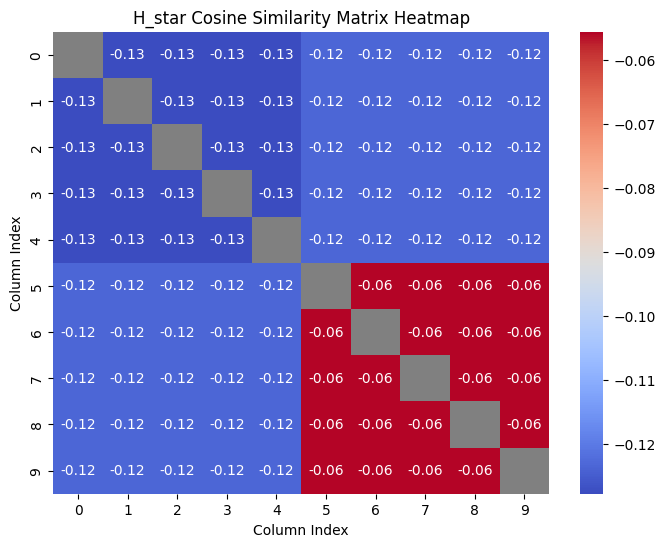

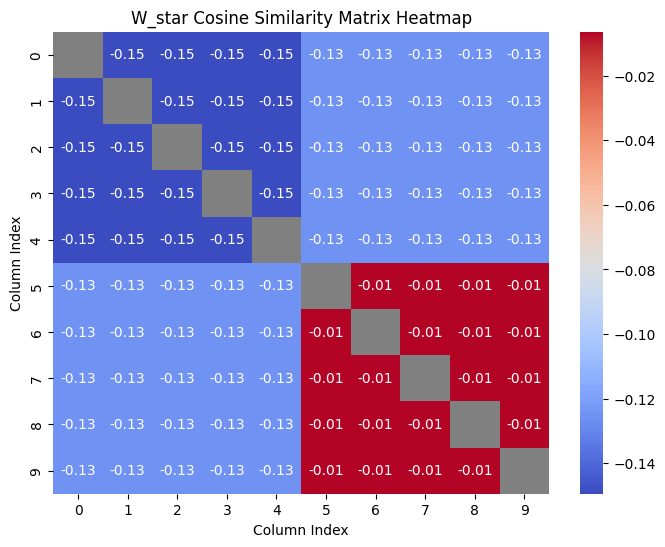

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_cosine_similarity(A, title):
    # Normalize the columns (L2-norm)
    A_normalized = A / np.linalg.norm(A, axis=0, keepdims=True)

    # Compute the cosine similarity matrix
    cosine_similarity_matrix = np.dot(A_normalized.T, A_normalized)

    # Create a mask to hide the diagonal values
    mask = np.zeros_like(cosine_similarity_matrix, dtype=bool)
    np.fill_diagonal(mask, True)

    # Create a custom colormap with gray color for masked values
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    cmap_gray = ListedColormap(cmap(np.arange(cmap.N)), "gray")
    cmap_gray.set_bad("gray")

    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cosine_similarity_matrix, annot=True, cmap=cmap_gray, cbar=True, fmt='.2f', mask=mask)

    # Set the title and labels
    plt.title(title)
    plt.xlabel("Column Index")
    plt.ylabel("Column Index")

    # Show the plot
    plt.show()

# Convert tensors to numpy arrays
H_star_np = H_star.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# Plot cosine similarity matrices
plot_cosine_similarity(H_star_np, "H_star Cosine Similarity Matrix Heatmap")
plot_cosine_similarity(W_star_np, "W_star Cosine Similarity Matrix Heatmap")


Files already downloaded and verified


Train Epoch: 29 [53/54 (98%)]	Loss: 0.097205: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


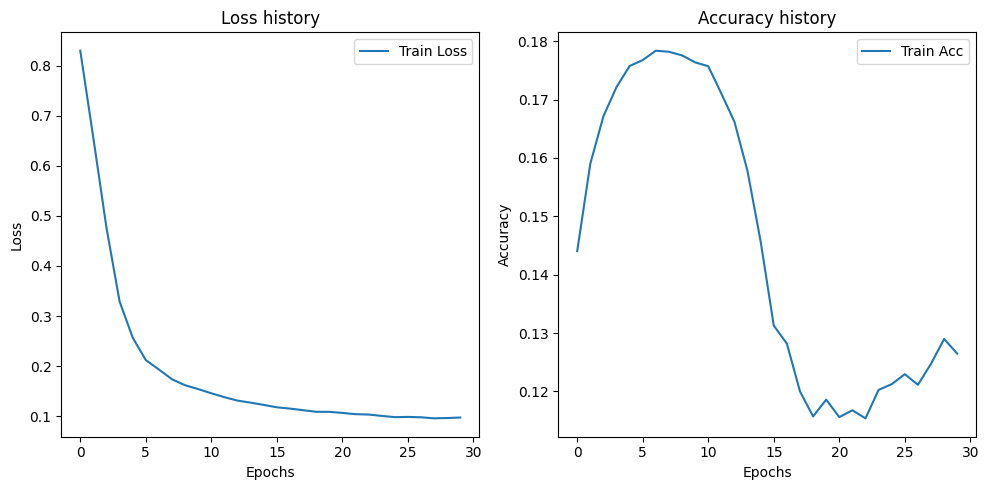

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)

# Create an imbalanced dataset
class_counts = np.bincount(trainset.targets)
num_samples = class_counts.copy()
num_samples[5:] = num_samples[5:] // 10  # Reduce the number of samples for the last 5 classes

indices = []
for class_id, num_sample in enumerate(num_samples):
    class_indices = np.where(np.array(trainset.targets) == class_id)[0]
    indices.append(class_indices[:num_sample])

indices = np.concatenate(indices)
imbalanced_trainset = torch.utils.data.Subset(trainset, indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                            download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=128,
#                                          shuffle=False, num_workers=2)


# Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 10)
resnet18.fc.bias.data.fill_(0)
resnet18 = resnet18.to(device)

# Define the feature extractor
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])

# Set the last layer weights to W_star
with torch.no_grad():
    resnet18.fc.weight.copy_(W_star.T)

# Define the optimizer
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(resnet18.parameters(), lr=0.00001)

# Define the loss function
mse_loss = nn.MSELoss()

# Lists for saving history
loss_history = []
acc_history = []

# Training loop
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(enumerate(trainloader), total=len(trainloader))
    for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = feature_extractor(inputs)
        outputs = outputs.view(outputs.size(0), -1)

        # Compute the mean feature for each class
        H = []
        for c in range(10):
            mask = (labels == c)
            H_c = torch.mean(outputs[mask], dim=0, keepdim=True)
            H.append(H_c)
        H = torch.cat(H, dim=0)

        loss = mse_loss(H, H_star.T)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(resnet18(inputs).data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_description(
            f"Train Epoch: {epoch} [{i}/{len(trainloader)} ({100.0 * i / len(trainloader):.0f}%)]\tLoss: {running_loss/(i+1):.6f}")

    loss_history.append(running_loss/len(trainloader))
    acc_history.append(correct / total)

import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend()

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend()

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend()

plt.tight_layout()
plt.show()


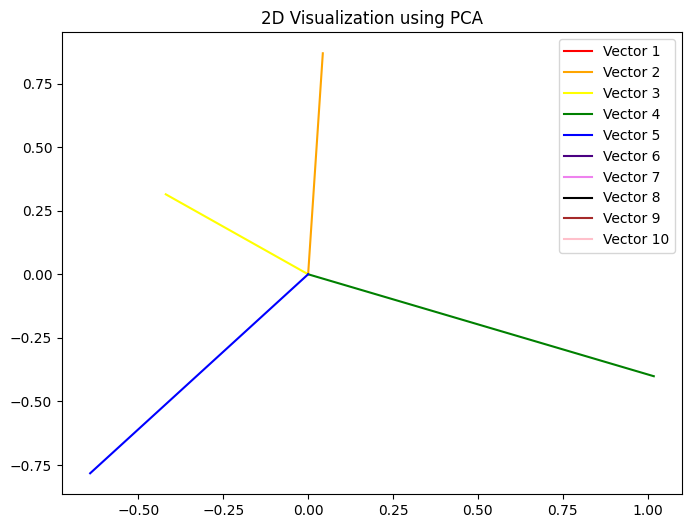

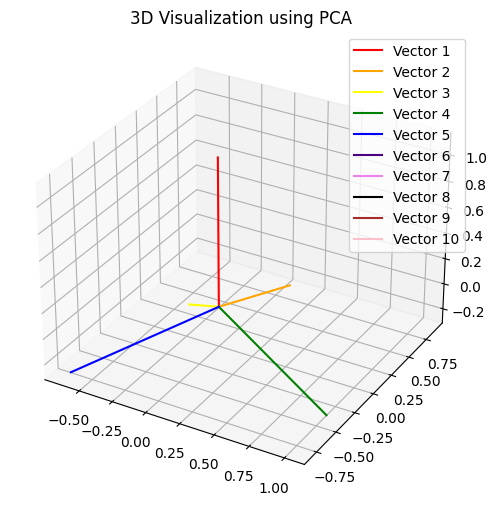

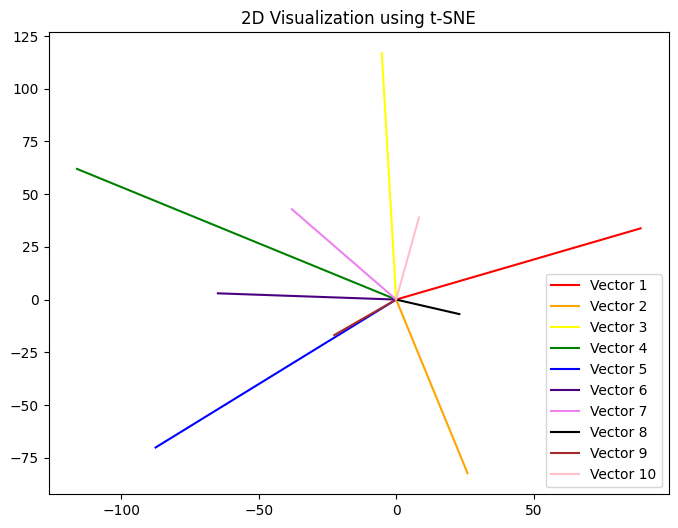

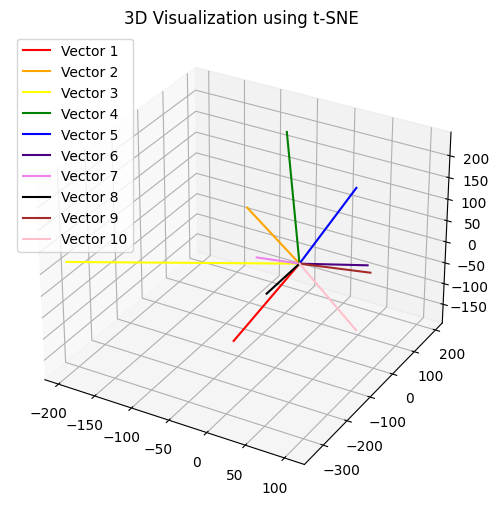

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# 假设你的数据存在变量 M_ 中，该变量是一个128x10的PyTorch Tensor

# 将PyTorch Tensor从CUDA设备移至CPU，然后转换为NumPy数组
data_np = M_.cpu().numpy().T  # 注意我们现在使用转置，因为我们希望每个向量成为一行，以便于降维处理

# 初始化PCA和t-SNE对象，n_components指定我们想要的主成分数量
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

tsne_2d = TSNE(n_components=2, perplexity=5)
tsne_3d = TSNE(n_components=3, perplexity=5)

# 使用PCA和t-SNE进行降维
methods_2d = [pca_2d, tsne_2d]
methods_3d = [pca_3d, tsne_3d]
method_names = ['PCA', 't-SNE']

# 创建一个颜色列表
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black', 'brown', 'pink']

for method_2d, method_3d, method_name in zip(methods_2d, methods_3d, method_names):
    # 降维
    data_2d = method_2d.fit_transform(data_np)
    data_3d = method_3d.fit_transform(data_np)

    # 2D可视化
    plt.figure(figsize=(8, 6))
    for i in range(data_2d.shape[0]):
        plt.plot([0, data_2d[i, 0]], [0, data_2d[i, 1]], color=colors[i], label=f'Vector {i+1}')
    plt.title(f'2D Visualization using {method_name}')
    plt.legend()
    plt.show()

    # 3D可视化
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(data_3d.shape[0]):
        ax.plot([0, data_3d[i, 0]], [0, data_3d[i, 1]], [0, data_3d[i, 2]], color=colors[i], label=f'Vector {i+1}')
    ax.set_title(f'3D Visualization using {method_name}')
    plt.legend()
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


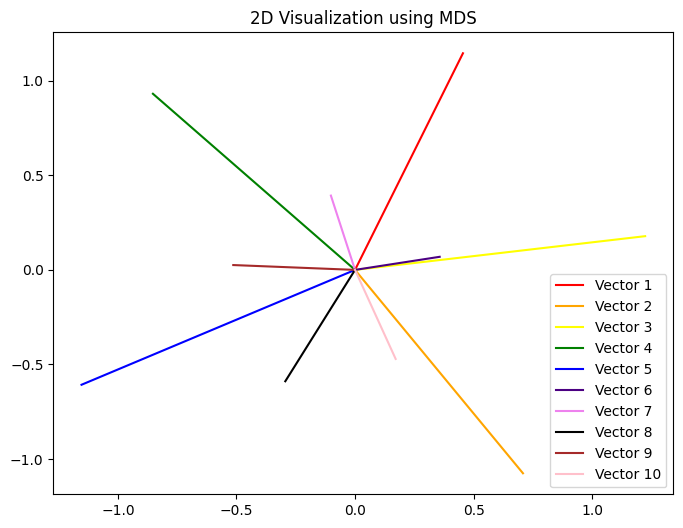

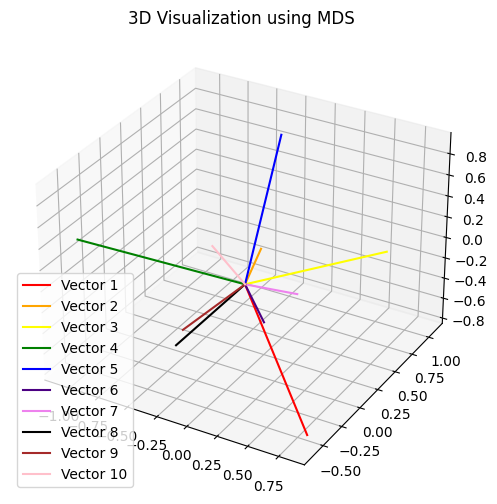

In [ ]:
from sklearn.manifold import MDS

# 初始化MDS对象，n_components指定我们想要的主成分数量
mds_2d = MDS(n_components=2)
mds_3d = MDS(n_components=3)

# 使用MDS进行降维
data_2d = mds_2d.fit_transform(data_np)
data_3d = mds_3d.fit_transform(data_np)

# 2D可视化
plt.figure(figsize=(8, 6))
for i in range(data_2d.shape[0]):
    plt.plot([0, data_2d[i, 0]], [0, data_2d[i, 1]], color=colors[i], label=f'Vector {i+1}')
plt.title('2D Visualization using MDS')
plt.legend()
plt.show()

# 3D可视化
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(data_3d.shape[0]):
    ax.plot([0, data_3d[i, 0]], [0, data_3d[i, 1]], [0, data_3d[i, 2]], color=colors[i], label=f'Vector {i+1}')
ax.set_title('3D Visualization using MDS')
plt.legend()
plt.show()


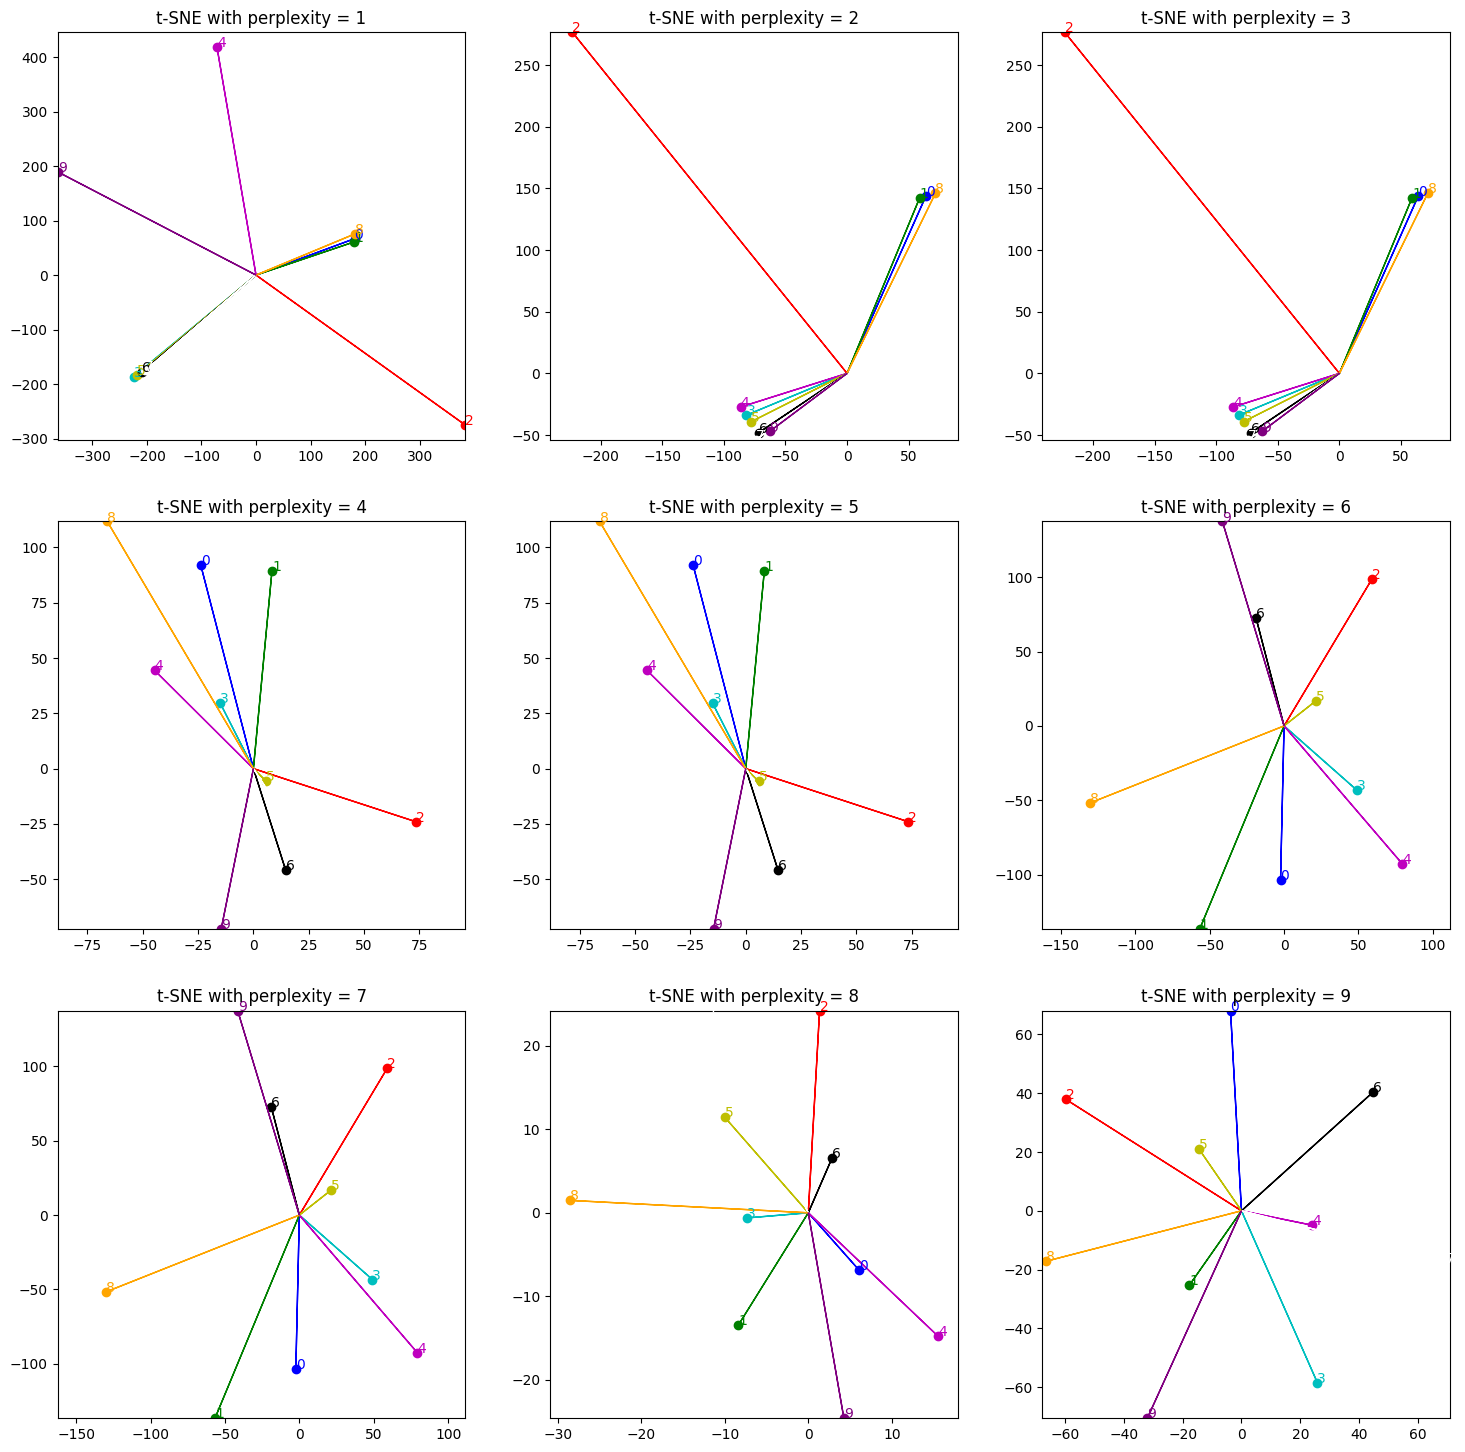

In [ ]:
# 导入所需的库
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 定义一些参数
perplexities = [1, 2, 3, 4, 5, 6, 7, 8, 9]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

# 转换为numpy数组
M_np = M_.cpu().numpy()

# 针对每个perplexity值进行t-SNE并绘图
plt.figure(figsize=(18, 18))
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    M_reduced = tsne.fit_transform(M_np.T)

    plt.subplot(3, 3, i+1)
    plt.title(f't-SNE with perplexity = {perplexity}')
    for j in range(M_reduced.shape[0]):
        # 绘制散点
        plt.scatter(M_reduced[j, 0], M_reduced[j, 1], color=colors[j])
        # 绘制带箭头的线
        plt.arrow(0, 0, M_reduced[j, 0], M_reduced[j, 1], color=colors[j], head_width=0.1, head_length=0.1)
        # 绘制文本标签
        plt.text(M_reduced[j, 0], M_reduced[j, 1], str(j), color=colors[j])

    # 获取当前图的最大和最小的x和y值
    xmax = np.max(M_reduced[:, 0])
    xmin = np.min(M_reduced[:, 0])
    ymax = np.max(M_reduced[:, 1])
    ymin = np.min(M_reduced[:, 1])

    # 计算最大的范围
    max_range = max(xmax - xmin, ymax - ymin)

    # 设置x和y轴的范围，保持原点在画面的正中间
    plt.xlim(xmin - (max_range - (xmax - xmin)) / 2, xmax + (max_range - (xmax - xmin)) / 2)
    plt.ylim(ymin - (max_range - (ymax - ymin)) / 2, ymax + (max_range - (ymax - ymin)) / 2)

    # 设置x和y轴的刻度相等，以保持单位的一致性
    plt.gca().set_aspect('equal', adjustable='box')
plt.show()
